# Clustering Exercises - Data Wrangling

In [27]:
import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(10, 8))
plt.rc('font', size=14)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

from env import host, user, password
import os

#import acquire
#import summarize
#import prepare

## acquire & summarize

1. Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.
    * Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.
    * Only include properties with a transaction in 2017, and include only the last transaction for each properity (so no duplicate property ID's), along with zestimate error and date of transaction.
    * Only include properties that include a latitude and longitude value.

2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

### acquire

In [2]:
#                JOIN(SELECT parcelid, logerror, max(transactiondate) AS lasttransactiondate
#                FROM predictions_2017
#                GROUP BY parcelid, logerror
#                ) AS predictions USING(parcelid)

In [3]:
# copy and pasted from my work on the regression project and then modified

def get_connection(db, user=user, host=host, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def get_zillow_data():   
    sql_query = '''
                SELECT *
                FROM properties_2017
                JOIN predictions_2017 USING(parcelid)
                LEFT JOIN airconditioningtype USING(airconditioningtypeid)
                LEFT JOIN architecturalstyletype USING(architecturalstyletypeid)
                LEFT JOIN buildingclasstype USING(buildingclasstypeid)
                LEFT JOIN heatingorsystemtype USING(heatingorsystemtypeid)
                LEFT JOIN propertylandusetype USING(propertylandusetypeid)
                LEFT JOIN storytype USING(storytypeid)
                LEFT JOIN typeconstructiontype USING(typeconstructiontypeid)
                LEFT JOIN unique_properties USING(parcelid)
                WHERE latitude is not null AND longitude is not null
                AND propertylandusetypeid = '261' OR '262' OR '263' OR '264' OR '268' OR '273' OR '274' OR '275' OR '276' OR '279';
                '''
    filename = "zillow_df.csv"
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
        #drop second index column
        df = df.drop(columns=['Unnamed: 0'])
        #drop duplicates
        df = df.drop_duplicates()
        return df
    else:
        # read the SQL query into a dataframe
        df = pd.read_sql(sql_query, get_connection('zillow'))
        # cache the dataframe
        df.to_csv(filename)
        
        # return the dataframe
        return df

In [4]:
df = get_zillow_data()
df.head()

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,id.1,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,nan,nan,261.00,nan,nan,nan,nan,1727539,nan,...,0,0.03,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,17052889,nan,nan,261.00,nan,nan,nan,nan,1387261,nan,...,1,0.06,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,14186244,nan,nan,261.00,nan,nan,nan,nan,11677,nan,...,2,0.01,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,12177905,nan,nan,261.00,2.00,nan,nan,nan,2288172,nan,...,3,-0.10,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,10887214,nan,nan,266.00,2.00,nan,nan,1.00,1970746,nan,...,4,0.01,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [5]:
df.columns

Index(['parcelid', 'typeconstructiontypeid', 'storytypeid',
       'propertylandusetypeid', 'heatingorsystemtypeid', 'buildingclasstypeid',
       'architecturalstyletypeid', 'airconditioningtypeid', 'id',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'latitude',
       'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'yardbuildingsqft17',

### summarize

In [6]:
#print('Shape:\n', df.shape, '\nInfo:\n', df.info(), '\nDescriptions:\n', df.describe(), '\nNulls by Column:\n', df.isnull().sum(), '\nNulls by Row:\n', df.isnull().sum(axis=1), '\nValue Counts:\n', df.count())

In [7]:
print('Shape:\n', df.shape)

Shape:
 (77614, 69)


In [8]:
print('\nInfo:\n', df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77614 entries, 0 to 77613
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77614 non-null  int64  
 1   typeconstructiontypeid        223 non-null    float64
 2   storytypeid                   50 non-null     float64
 3   propertylandusetypeid         77580 non-null  float64
 4   heatingorsystemtypeid         49572 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   architecturalstyletypeid      207 non-null    float64
 7   airconditioningtypeid         25007 non-null  float64
 8   id                            77614 non-null  int64  
 9   basementsqft                  50 non-null     float64
 10  bathroomcnt                   77580 non-null  float64
 11  bedroomcnt                    77580 non-null  float64
 12  buildingqualitytypeid         49810 non-null  float64
 13  c

In [9]:
print('\nDescriptions:\n', df.describe())


Descriptions:
                   parcelid  typeconstructiontypeid          storytypeid  \
count            77,614.00                  223.00                50.00   
mean         13,007,807.98                    6.04                 7.00   
std           3,518,694.35                    0.56                 0.00   
min          10,711,855.00                    4.00                 7.00   
25%          11,538,214.00                    6.00                 7.00   
50%          12,530,061.50                    6.00                 7.00   
75%          14,211,001.25                    6.00                 7.00   
max         167,689,317.00                   13.00                 7.00   

       propertylandusetypeid  heatingorsystemtypeid  buildingclasstypeid  \
count              77,580.00              49,572.00                15.00   
mean                  261.82                   3.92                 3.93   
std                     5.14                   3.59                 0.26   
min 

In [10]:
print('\nNulls by Column:\n', df.isnull().sum())


Nulls by Column:
 parcelid                      0
typeconstructiontypeid    77391
storytypeid               77564
propertylandusetypeid        34
heatingorsystemtypeid     28042
                          ...  
buildingclassdesc         77599
heatingorsystemdesc       28042
propertylandusedesc          34
storydesc                 77564
typeconstructiondesc      77391
Length: 69, dtype: int64


In [11]:
print('\nNulls by Row:\n', df.isnull().sum(axis=1))


Nulls by Row:
 0        36
1        33
2        34
3        32
4        29
         ..
77609    33
77610    32
77611    32
77612    34
77613    34
Length: 77614, dtype: int64


In [12]:
print('\nValue Counts:\n', df.count())


Value Counts:
 parcelid                  77614
typeconstructiontypeid      223
storytypeid                  50
propertylandusetypeid     77580
heatingorsystemtypeid     49572
                          ...  
buildingclassdesc            15
heatingorsystemdesc       49572
propertylandusedesc       77580
storydesc                    50
typeconstructiondesc        223
Length: 69, dtype: int64


### missing values dataframe function

In [13]:
df.nunique()

parcelid                  77414
typeconstructiontypeid        4
storytypeid                   1
propertylandusetypeid        13
heatingorsystemtypeid        10
                          ...  
buildingclassdesc             2
heatingorsystemdesc          10
propertylandusedesc          13
storydesc                     1
typeconstructiondesc          4
Length: 69, dtype: int64

In [14]:
def missing_values_df(df):
    '''
    This functions takes in a dataframe of observations and attributes
    and returns a dataframe where each row is an atttribute name,
    the first column is the number of rows with missing values for that attribute,
    and the second column is percent of total rows that have missing values for that attribute.
    '''
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    pct_missing = num_missing / rows
    df = pd.DataFrame({'number_missing_rows': num_missing, 'percent_rows_missing': pct_missing})
    return df

In [15]:
missing_values = missing_values_df(df)
missing_values.sort_values(by='percent_rows_missing', ascending=False, inplace=True)
missing_values.head(30)

,number_missing_rows,percent_rows_missing
buildingclassdesc,77599,1.00
buildingclasstypeid,77599,1.00
finishedsquarefeet13,77572,1.00
storytypeid,77564,1.00
storydesc,77564,1.00
basementsqft,77564,1.00
yardbuildingsqft26,77544,1.00
fireplaceflag,77442,1.00
architecturalstyletypeid,77407,1.00
architecturalstyledesc,77407,1.00


In [16]:
missing_values.sort_values(by='percent_rows_missing', ascending=True, inplace=True)
missing_values.head(30)

,number_missing_rows,percent_rows_missing
parcelid,0,0.00
id,0,0.00
transactiondate,0,0.00
logerror,0,0.00
id.1,0,0.00
fips,34,0.00
latitude,34,0.00
longitude,34,0.00
bedroomcnt,34,0.00
propertycountylandusecode,34,0.00


 * Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values.

In [17]:
def missing_info(df):
    num_cols_missing = df.isnull().sum(axis=1)
    pct_cols_missing = df.isnull().sum(axis=1)/df.shape[1]*100
    df = pd.DataFrame({'num_cols_missing': num_cols_missing, 'pct_cols_missing': pct_cols_missing}).reset_index().groupby(['num_cols_missing','pct_cols_missing']).count().rename(index=str, columns={'index': 'num_rows'}).reset_index()
    return df

missing_info = missing_info(df)
missing_info.sort_values(by="pct_cols_missing", ascending=False, inplace=True)
missing_info

,num_cols_missing,pct_cols_missing,num_rows
26,64,92.7536231884058,34
25,48,69.56521739130434,3
24,47,68.11594202898551,3
23,46,66.66666666666666,5
22,45,65.21739130434783,50
21,44,63.76811594202898,79
20,43,62.31884057971014,29
19,42,60.86956521739131,27
18,41,59.42028985507246,29
17,40,57.971014492753625,230


**Takeaways:**
   * Using the information I gained above, I will choose how to handle my null values.
     * Drop columns that have 90%+ null rows.
     * Drop rows that have 60%+ null columns.

In [18]:
df.columns.tolist()

['parcelid',
 'typeconstructiontypeid',
 'storytypeid',
 'propertylandusetypeid',
 'heatingorsystemtypeid',
 'buildingclasstypeid',
 'architecturalstyletypeid',
 'airconditioningtypeid',
 'id',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'threequarterbathnbr',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',


## prepare

1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.

2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).
 * The input:
 
   * A dataframe
   * A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
   * A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).
   
 * The output:
 
   * The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.
   
 * hint:
 
   * Look up the dropna documentation.
   * You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
   * Make use of inplace, i.e. inplace=True/False.
   
3. Decide how to handle the remaining missing values:
 * Fill with constant value.
 * Impute with mean, median, mode.
 * Drop row/column
 
**wrangle_zillow.py**

Functions of the work above needed to acquire and prepare a new sample of data.

### Remove any properties that are likely to be something other than single unit properties.

In [20]:
df.bedroomcnt.value_counts()

 3.00    30437
 2.00    19223
 4.00    17551
 5.00     4550
 1.00     3391
 6.00     1000
 0.00      837
 8.00      253
 7.00      208
 9.00       70
10.00       31
12.00       16
11.00        9
13.00        2
16.00        1
14.00        1
Name: bedroomcnt, dtype: int64

In [21]:
df.shape

(77614, 69)

In [29]:
# Select all cases where rooms are null or rooms are less than 10 and set as new df
df = df.loc[(df['bedroomcnt'].isnull() | (df['bedroomcnt'] < 10.00))]
df.shape

(77554, 69)

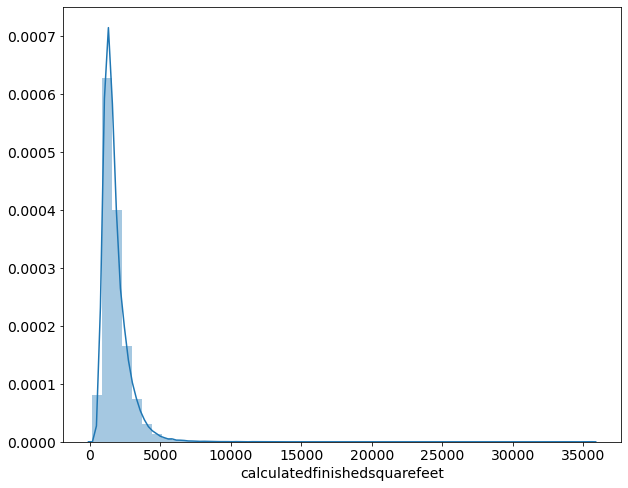

In [30]:
sns.distplot(df.calculatedfinishedsquarefeet)

In [31]:
df.calculatedfinishedsquarefeet.describe()

count              77,319.00
mean                1,782.45
std                   947.50
min                   128.00
25%                 1,182.00
50%                 1,541.00
75%                 2,110.00
max                35,640.00
Name: calculatedfinishedsquarefeet, dtype: float64

In [32]:
# filter by getting rid of any properties that are 8,000+ sq ft. (or null)
df = df.loc[(df['calculatedfinishedsquarefeet'].isnull() | (df['calculatedfinishedsquarefeet'] < 8000.00))]
df.shape

(77443, 69)

In [33]:
# Filter out anything that's a duplexes and above, or null
df = df.loc[(df['unitcnt'].isnull() | (df['unitcnt'] <= 1.00))]
df.shape

(74212, 69)

### Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

In [34]:
def handle_missing_values(df, prop_required_column, prop_required_row):
    '''
    This function takes in a df, a proportion of columns (as between 0 and 1) for each row
    that has to be non-null in order to keep the row in the df, and a proportion of rows (as
    between 0 and 1) for each column that has to be non-null in order to keep the column in the df.
    '''
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [41]:
df = handle_missing_values(df, .9, .9)
df.shape

(73964, 29)

### Decide how to handle the remaining missing values.

* Fill with constant value.
* Impute with mean, median, mode.
* Drop row/column

In [ ]:
# Do a train validate test split before imputing!

In [42]:
df.isnull().sum()

parcelid                           0
propertylandusetypeid              0
id                                 0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                 96
calculatedfinishedsquarefeet      10
finishedsquarefeet12             259
fips                               0
fullbathcnt                       96
latitude                           0
longitude                          0
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1432
regionidcounty                     0
regionidzip                       36
roomcnt                            0
yearbuilt                         43
structuretaxvaluedollarcnt        71
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          5
censustractandblock              207
id.1                               0
logerror                           0
t

In [43]:
#df.finishedsquarefeet12.describe()
#df.calculatedfinishedsquarefeet.describe()

# drop unneeded features
df = df.drop(columns=['id', 'id.1', 'finishedsquarefeet12'])
df.head()

,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,14297519,261.00,3.50,4.00,3.50,"3,100.00","3,100.00","6,059.00",3.00,"33,634,931.00",...,"1,998.00","485,713.00","1,023,282.00","2,016.00","537,569.00","11,013.72","60,590,630,072,012.00",0.03,2017-01-01,Single Family Residential
1,17052889,261.00,1.00,2.00,1.00,"1,465.00","1,465.00","6,111.00",1.00,"34,449,266.00",...,"1,967.00","88,000.00","464,000.00","2,016.00","376,000.00","5,672.48","61,110,010,023,006.00",0.06,2017-01-01,Single Family Residential
2,14186244,261.00,2.00,3.00,2.00,"1,243.00","1,243.00","6,059.00",2.00,"33,886,168.00",...,"1,962.00","85,289.00","564,778.00","2,016.00","479,489.00","6,488.30","60,590,218,022,012.00",0.01,2017-01-01,Single Family Residential
3,12177905,261.00,3.00,4.00,3.00,"2,376.00","2,376.00","6,037.00",3.00,"34,245,180.00",...,"1,970.00","108,918.00","145,143.00","2,016.00","36,225.00","1,777.51","60,373,001,001,006.00",-0.10,2017-01-01,Single Family Residential
4,10887214,266.00,3.00,3.00,3.00,"1,312.00","1,312.00","6,037.00",3.00,"34,185,120.00",...,"1,964.00","73,681.00","119,407.00","2,016.00","45,726.00","1,533.89","60,371,236,012,000.00",0.01,2017-01-01,Condominium


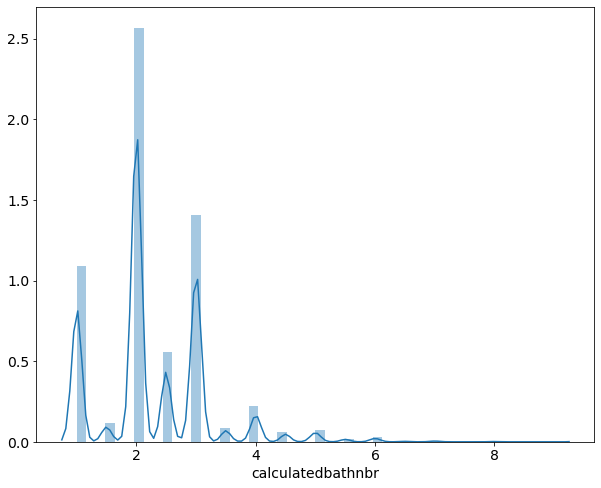

In [44]:
sns.distplot(df.calculatedbathnbr)

In [45]:
df.calculatedbathnbr.describe()

count              73,868.00
mean                    2.28
std                     0.92
min                     1.00
25%                     2.00
50%                     2.00
75%                     3.00
max                     9.00
Name: calculatedbathnbr, dtype: float64

In [49]:
#impute median for calculatedbathnbr
df.calculatedbathnbr = df.calculatedbathnbr.fillna(df.calculatedbathnbr.median())
df.head()

,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,14297519,261.00,3.50,4.00,3.50,"3,100.00","3,100.00","6,059.00",3.00,"33,634,931.00",...,"1,998.00","485,713.00","1,023,282.00","2,016.00","537,569.00","11,013.72","60,590,630,072,012.00",0.03,2017-01-01,Single Family Residential
1,17052889,261.00,1.00,2.00,1.00,"1,465.00","1,465.00","6,111.00",1.00,"34,449,266.00",...,"1,967.00","88,000.00","464,000.00","2,016.00","376,000.00","5,672.48","61,110,010,023,006.00",0.06,2017-01-01,Single Family Residential
2,14186244,261.00,2.00,3.00,2.00,"1,243.00","1,243.00","6,059.00",2.00,"33,886,168.00",...,"1,962.00","85,289.00","564,778.00","2,016.00","479,489.00","6,488.30","60,590,218,022,012.00",0.01,2017-01-01,Single Family Residential
3,12177905,261.00,3.00,4.00,3.00,"2,376.00","2,376.00","6,037.00",3.00,"34,245,180.00",...,"1,970.00","108,918.00","145,143.00","2,016.00","36,225.00","1,777.51","60,373,001,001,006.00",-0.10,2017-01-01,Single Family Residential
4,10887214,266.00,3.00,3.00,3.00,"1,312.00","1,312.00","6,037.00",3.00,"34,185,120.00",...,"1,964.00","73,681.00","119,407.00","2,016.00","45,726.00","1,533.89","60,371,236,012,000.00",0.01,2017-01-01,Condominium


In [50]:
df.shape

(73964, 27)

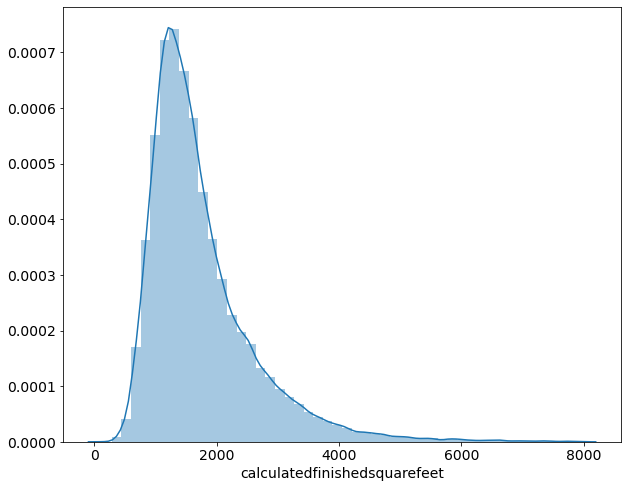

In [52]:
sns.distplot(df.calculatedfinishedsquarefeet)

In [53]:
df.calculatedfinishedsquarefeet.describe()

count              73,954.00
mean                1,745.37
std                   873.99
min                   128.00
25%                 1,170.00
50%                 1,520.00
75%                 2,068.00
max                 7,970.00
Name: calculatedfinishedsquarefeet, dtype: float64

In [54]:
#impute mean for calculatedfinishedsquarefeet
df.calculatedfinishedsquarefeet = df.calculatedfinishedsquarefeet.fillna(df.calculatedfinishedsquarefeet.mean())
df.head()

,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,14297519,261.00,3.50,4.00,3.50,"3,100.00","3,100.00","6,059.00",3.00,"33,634,931.00",...,"1,998.00","485,713.00","1,023,282.00","2,016.00","537,569.00","11,013.72","60,590,630,072,012.00",0.03,2017-01-01,Single Family Residential
1,17052889,261.00,1.00,2.00,1.00,"1,465.00","1,465.00","6,111.00",1.00,"34,449,266.00",...,"1,967.00","88,000.00","464,000.00","2,016.00","376,000.00","5,672.48","61,110,010,023,006.00",0.06,2017-01-01,Single Family Residential
2,14186244,261.00,2.00,3.00,2.00,"1,243.00","1,243.00","6,059.00",2.00,"33,886,168.00",...,"1,962.00","85,289.00","564,778.00","2,016.00","479,489.00","6,488.30","60,590,218,022,012.00",0.01,2017-01-01,Single Family Residential
3,12177905,261.00,3.00,4.00,3.00,"2,376.00","2,376.00","6,037.00",3.00,"34,245,180.00",...,"1,970.00","108,918.00","145,143.00","2,016.00","36,225.00","1,777.51","60,373,001,001,006.00",-0.10,2017-01-01,Single Family Residential
4,10887214,266.00,3.00,3.00,3.00,"1,312.00","1,312.00","6,037.00",3.00,"34,185,120.00",...,"1,964.00","73,681.00","119,407.00","2,016.00","45,726.00","1,533.89","60,371,236,012,000.00",0.01,2017-01-01,Condominium


In [70]:
#impute mode for regionidcity
df.regionidcity = df.regionidcity.fillna(df.regionidcity.mode())

#impute mode for regionidzip
df.regionidzip = df.regionidzip.fillna(df.regionidzip.mode())

#impute mode for yearbuilt
df.yearbuilt = df.yearbuilt.fillna(df.yearbuilt.mode())

#impute mode for landtaxvaluedollarcnt
df.landtaxvaluedollarcnt = df.landtaxvaluedollarcnt.fillna(df.landtaxvaluedollarcnt.mode())

df.head()

,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,14297519,261.00,3.50,4.00,3.50,"3,100.00","6,059.00",3.00,"33,634,931.00","-117,869,207.00",...,"1,998.00","485,713.00","1,023,282.00","2,016.00","537,569.00","11,013.72","60,590,630,072,012.00",0.03,2017-01-01,Single Family Residential
1,17052889,261.00,1.00,2.00,1.00,"1,465.00","6,111.00",1.00,"34,449,266.00","-119,281,531.00",...,"1,967.00","88,000.00","464,000.00","2,016.00","376,000.00","5,672.48","61,110,010,023,006.00",0.06,2017-01-01,Single Family Residential
2,14186244,261.00,2.00,3.00,2.00,"1,243.00","6,059.00",2.00,"33,886,168.00","-117,823,170.00",...,"1,962.00","85,289.00","564,778.00","2,016.00","479,489.00","6,488.30","60,590,218,022,012.00",0.01,2017-01-01,Single Family Residential
3,12177905,261.00,3.00,4.00,3.00,"2,376.00","6,037.00",3.00,"34,245,180.00","-118,240,722.00",...,"1,970.00","108,918.00","145,143.00","2,016.00","36,225.00","1,777.51","60,373,001,001,006.00",-0.10,2017-01-01,Single Family Residential
4,10887214,266.00,3.00,3.00,3.00,"1,312.00","6,037.00",3.00,"34,185,120.00","-118,414,640.00",...,"1,964.00","73,681.00","119,407.00","2,016.00","45,726.00","1,533.89","60,371,236,012,000.00",0.01,2017-01-01,Condominium


In [71]:
df.regionidcity.mode()

0              12,447.00
dtype: float64

In [72]:
df.isnull().sum()

parcelid                           0
propertylandusetypeid              0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                  0
calculatedfinishedsquarefeet       0
fips                               0
fullbathcnt                       96
latitude                           0
longitude                          0
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1432
regionidcounty                     0
regionidzip                       36
roomcnt                            0
yearbuilt                         43
structuretaxvaluedollarcnt        71
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          5
censustractandblock              207
logerror                           0
transactiondate                    0
propertylandusedesc                0
dtype: int64

In [ ]:
structuretaxvaluedollarcnt
taxvaluedollarcnt
taxamount
censustractandblock